### Business Use Case:
This project aims to build a predictive model for flight fare estimation, enabling airlines, travel agencies, and customers to make informed decisions. By analyzing key flight attributes such as airline, source, destination, duration, and number of stops, the model provides accurate price predictions, helping businesses optimize pricing strategies and assisting travelers in budget planning.

### Importing the required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from sklearn.model_selection import GridSearchCV
import joblib

import warnings
warnings.filterwarnings('ignore')

### Loading and understanding the dataset

In [2]:
# Load the dataset
df = pd.read_excel('Data_Train.xlsx')
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [3]:
df.shape

(10683, 11)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [5]:
df.columns

Index(['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Route',
       'Dep_Time', 'Arrival_Time', 'Duration', 'Total_Stops',
       'Additional_Info', 'Price'],
      dtype='object')

In [6]:
df.dtypes

Airline            object
Date_of_Journey    object
Source             object
Destination        object
Route              object
Dep_Time           object
Arrival_Time       object
Duration           object
Total_Stops        object
Additional_Info    object
Price               int64
dtype: object

Here, Date_of_Journey, Dep_Time, and Arrival_Time are in object format, so we need to convert them to datetime format.

In [7]:
df['Date_of_Journey'] = pd.to_datetime(df['Date_of_Journey'])
df['Dep_Time'] = pd.to_datetime(df['Dep_Time'])
df['Arrival_Time'] = pd.to_datetime(df['Arrival_Time'])

In [8]:
# Checking null values
df.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

Here, we are dropping the null values as they are minimal, and removing them will not affect the prediction.

In [9]:
df = df.dropna()

### Exploratory Data Analysis

In [10]:
# Removing redundant columns
df = df.drop(['Route','Additional_Info'],axis=1)

In [11]:
df.head()

,Airline,Date_of_Journey,Source,Destination,Dep_Time,Arrival_Time,Duration,Total_Stops,Price
0,IndiGo,2019-03-24,Banglore,New Delhi,2025-03-17 22:20:00,2025-03-22 01:10:00,2h 50m,non-stop,3897
1,Air India,2019-05-01,Kolkata,Banglore,2025-03-17 05:50:00,2025-03-17 13:15:00,7h 25m,2 stops,7662
2,Jet Airways,2019-06-09,Delhi,Cochin,2025-03-17 09:25:00,2025-06-10 04:25:00,19h,2 stops,13882
3,IndiGo,2019-05-12,Kolkata,Banglore,2025-03-17 18:05:00,2025-03-17 23:30:00,5h 25m,1 stop,6218
4,IndiGo,2019-03-01,Banglore,New Delhi,2025-03-17 16:50:00,2025-03-17 21:35:00,4h 45m,1 stop,13302


#### Feature Engineering

##### Date_of_Journey column

In [12]:
## Extracting day and month from (Date_of_Journey) column
df['Journey_day'] = df['Date_of_Journey'].dt.day
df['Journey_month'] = df['Date_of_Journey'].dt.month

## Dropping (Date_of_Journey) column
df = df.drop('Date_of_Journey',axis=1)

##### Dep_Time and Arrival_Time columns

In [13]:
## Extracting hours and minutes
for col in ['Dep_Time','Arrival_Time']:
    df[col +'_hours'] = df[col].dt.hour
    df[col +'_minutes'] = df[col].dt.minute
    
    ## Removing columns
    df = df.drop(col,axis=1)

##### Duration column

In [14]:
# Duration column
duration = list(df['Duration'])
for i in range(len(duration)):
    if len(duration[i].split(' ')) == 2:
        pass
    else:
        if 'h' in duration[i]:
            duration[i] = duration[i] + ' 0m'
        else:
            duration[i]='0h ' + duration[i]
df['Duration'] = duration

In [15]:
def hour(x):
    return x.split(' ')[0][0:-1]
def minutes(x):
    return x.split(' ')[1][0:-1]

# Extracting columns from Duration and changing datatype
df['Dur_hour'] = df['Duration'].apply(hour).astype(int)
df['Dur_min'] = df['Duration'].apply(minutes).astype(int)

# Removing Duration column
df = df.drop('Duration',axis=1)

#### Data Visualization

<Axes: xlabel='Price', ylabel='Count'>

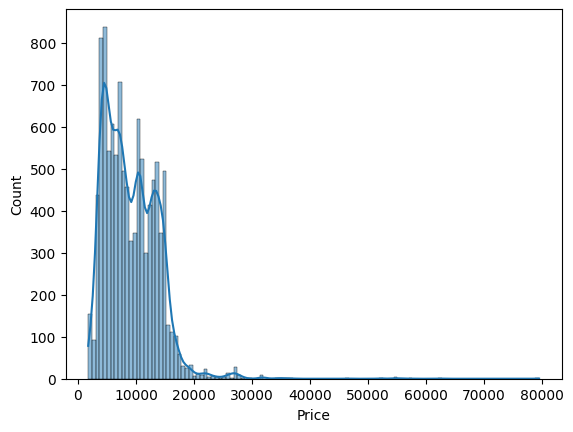

In [16]:
# Distribution of Price
sns.histplot(x=df['Price'],kde=True)

Flight prices are highly skewed to the right, indicating that while most flights are affordable, a few are exceptionally expensive.

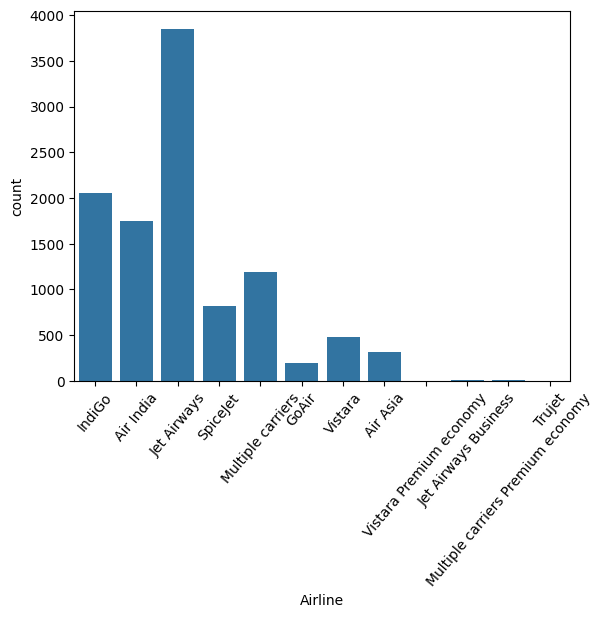

In [17]:
# Airline Count
sns.countplot(x=df['Airline'],data=df)
plt.xticks(rotation=(50))
plt.show()

Jet Airways operates the highest number of flights in the dataset, Airlines like Trujet have minimal representation.

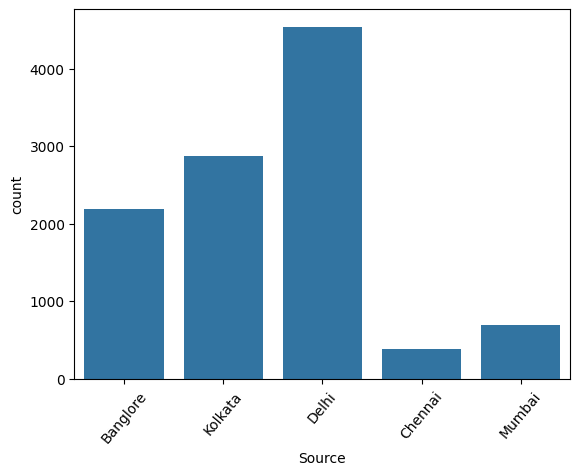

In [18]:
# Sources Count
sns.countplot(x=df['Source'],data=df)
plt.xticks(rotation=(50))
plt.show()

Delhi is the most common source location for flights, likely due to its role as a major hub in India. Other sources such as Mumbai and Chennai have fewer flights.

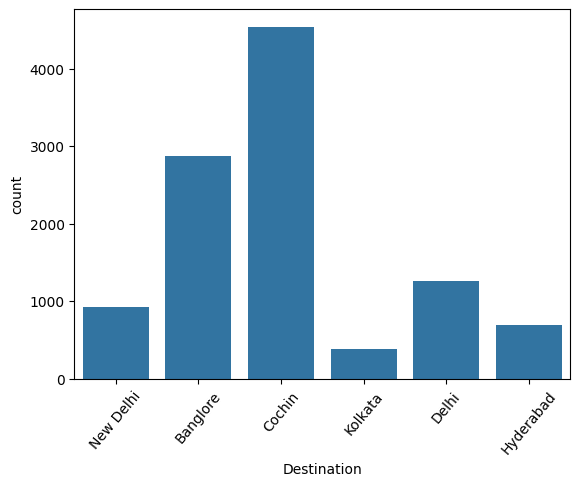

In [19]:
# Destinations Count
sns.countplot(x=df['Destination'],data=df)
plt.xticks(rotation=(50))
plt.show()

Cochin is the most common destination, with the highest number of flights arriving there.

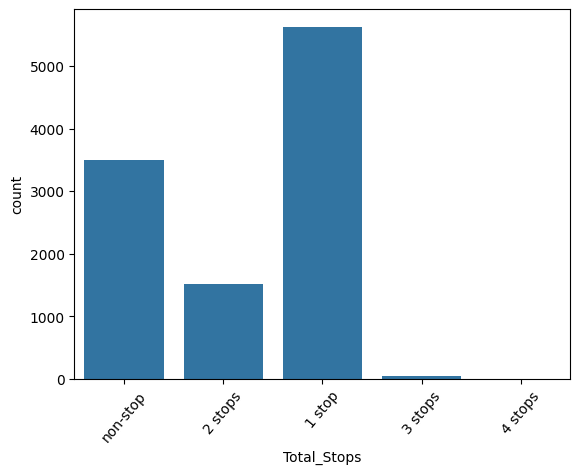

In [20]:
# Total_Stops Count
sns.countplot(x=df['Total_Stops'],data=df)
plt.xticks(rotation=(50))
plt.show()

The majority of flights have one stop, suggesting that direct routes are less common, and layovers are typical for longer routes.

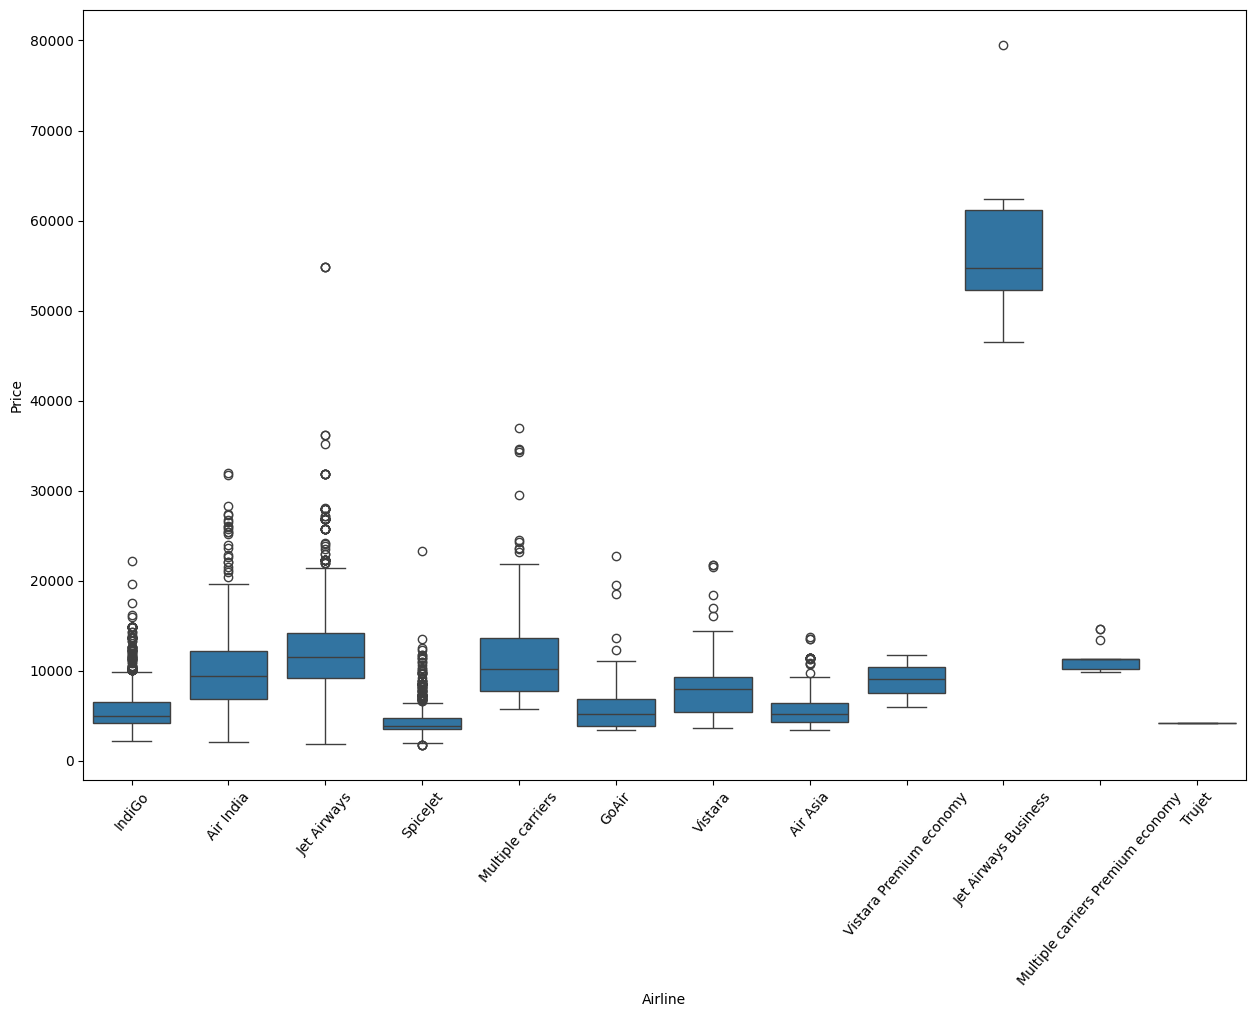

In [21]:
# Airline vs Price
plt.figure(figsize=(15,10))
sns.boxplot(x=df['Airline'],y=df['Price'],data=df.sort_values('Price',ascending=False))
plt.xticks(rotation=(50))
plt.show()

Jet Airways Business class flights are the most expensive, while Air Asia offers relatively budget-friendly price.

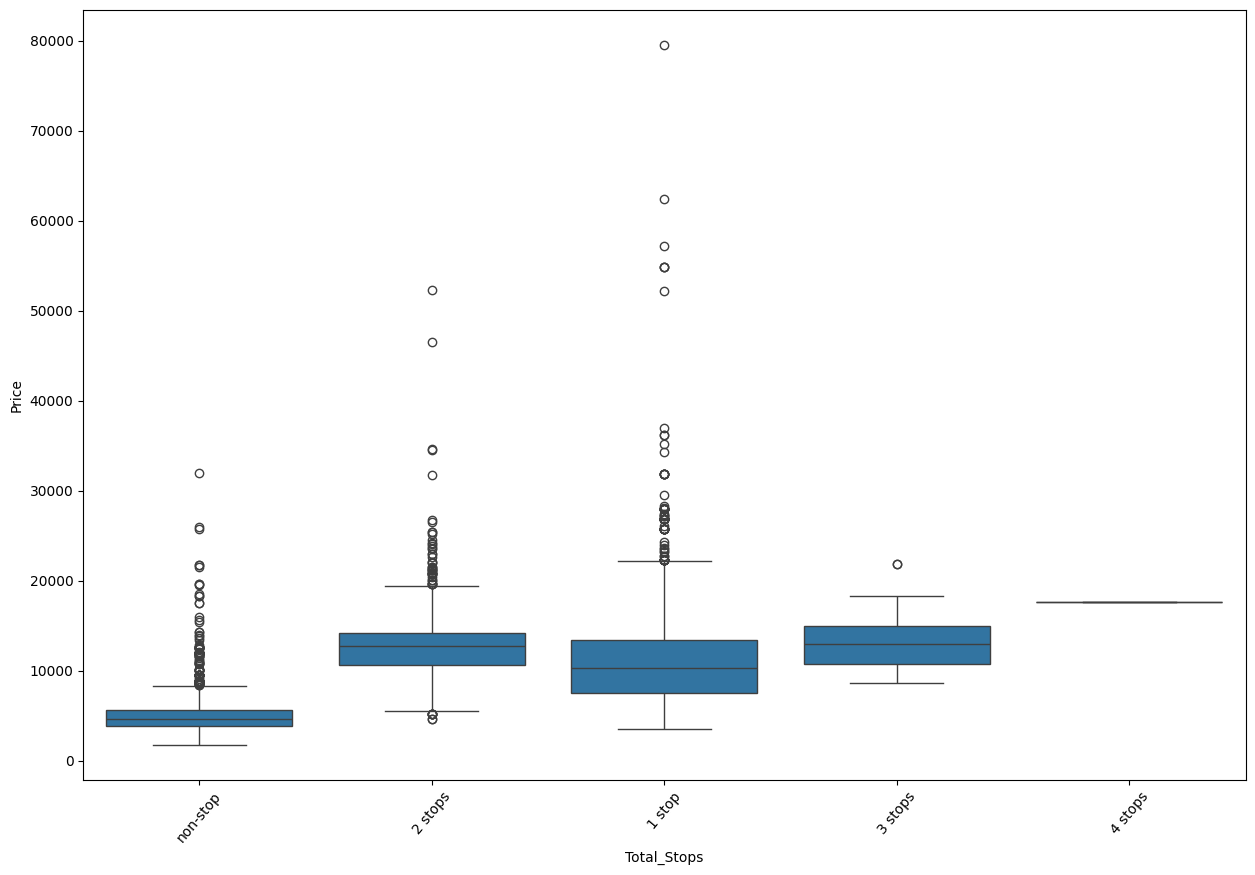

In [22]:
# Total_Stops vs Price
plt.figure(figsize=(15,10))
sns.boxplot(x=df['Total_Stops'],y=df['Price'],data=df.sort_values('Price',ascending=False))
plt.xticks(rotation=(50))
plt.show()

Flights with one stop are generally more expensive than non-stop or multi-stop flights. This could be due to strategic pricing by airlines or layover durations.

<Axes: xlabel='Total_Stops', ylabel='Dur_hour'>

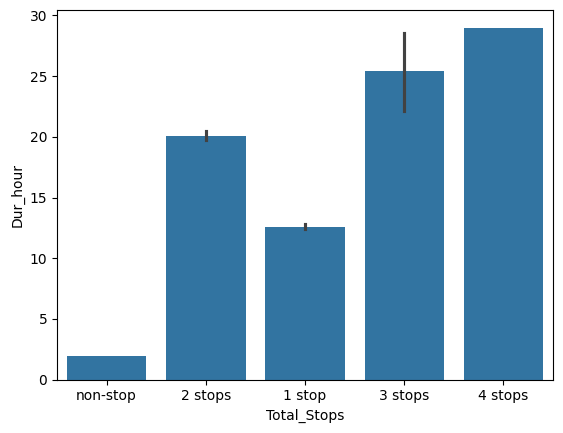

In [23]:
# Total stops and Dur_hour
sns.barplot(x=df['Total_Stops'],y=df['Dur_hour'])

Flights with four stops have the longest travel duration, as expected, due to multiple layovers. Non-stop flights are the quickest option.

<Axes: xlabel='count', ylabel='Airline'>

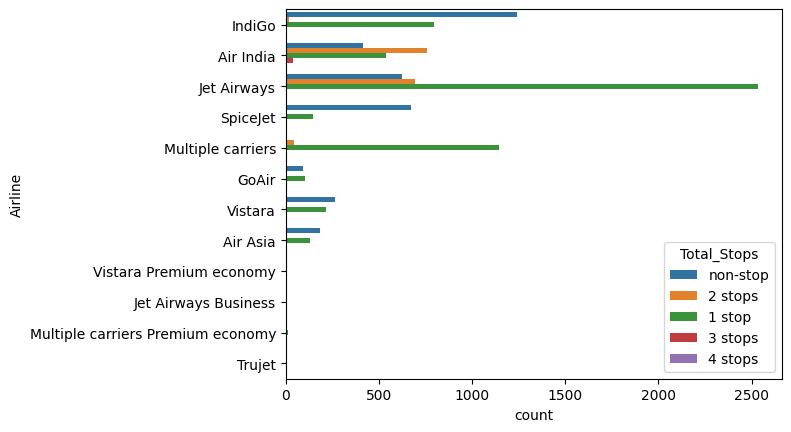

In [24]:
# Airline and Total Stops
sns.countplot(data=df, y='Airline', hue='Total_Stops')

The distribution of total stops for each airline, highlighting how different airlines operate flights with varying numbers of stops.

<Axes: >

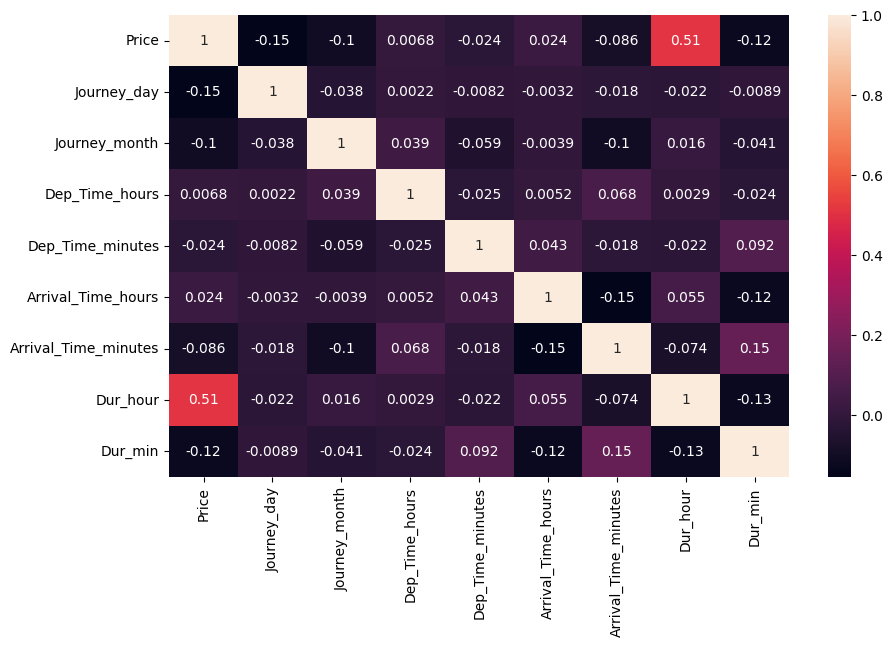

In [25]:
# Correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(data=df.select_dtypes(include=['number']).corr(),annot=True)

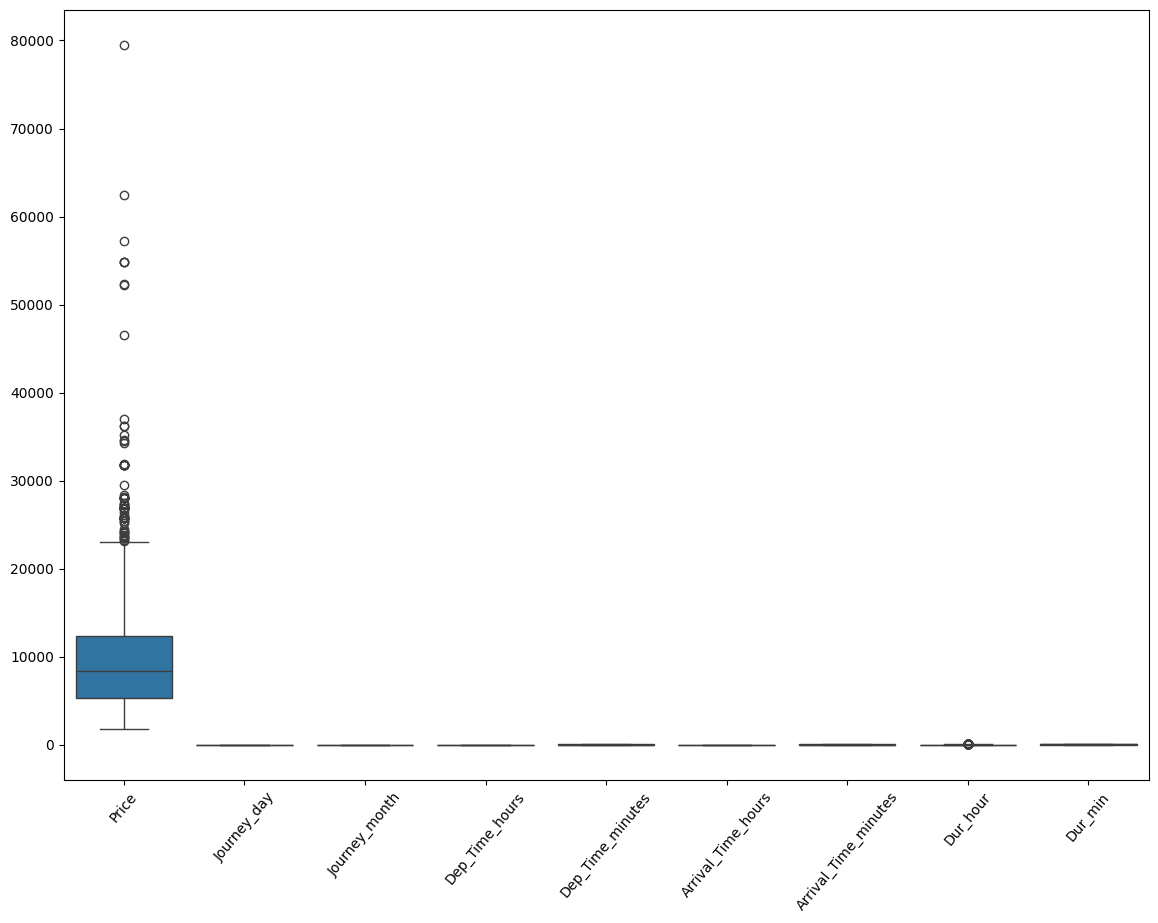

In [26]:
# Checking for Outliers
plt.figure(figsize=(14,10))
sns.boxplot(data=df)
plt.xticks(rotation=(50))
plt.show()

Outliers are primarily present in the Price column, likely due to luxury airline classes or unusually long-distance flights.

### Data Preprocessing

#### Handling Outliers
In the Price column, values above 40,000 are considered outliers and are replacing with the median to reduce their impact on the analysis.-

In [27]:
df['Price']=np.where(df['Price']>=40000,df['Price'].median(),df['Price'])

#### Encoding categorical data

In [28]:
Airline = df[['Airline']]
Airline = pd.get_dummies(Airline,drop_first=True).astype(int)
Airline.head()

,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy
0,0,0,1,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0


In [29]:
Source = df[['Source']]
Source = pd.get_dummies(Source,drop_first=True).astype(int)
Source.head()

,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai
0,0,0,0,0
1,0,0,1,0
2,0,1,0,0
3,0,0,1,0
4,0,0,0,0


In [30]:
Destination = df[['Destination']]
Destination = pd.get_dummies(Destination,drop_first=True).astype(int)
Destination.head()

,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,0,0,0,0,1
1,0,0,0,0,0
2,1,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,1


In [31]:
# Mapping total stops to numerical values
stops_mapping = {'non-stop':0,'1 stop':1,'2 stops':2,'3 stops':3,'4 stops':4}
df['Total_Stops'] = df['Total_Stops'].map(stops_mapping)

In [32]:
# Dropping columns
df = df.drop(columns=['Airline','Source','Destination'],axis=1)

In [33]:
# Combining encoded data to df
final_df = pd.concat([df,Airline,Source,Destination],axis=1)

In [34]:
final_df.shape

(10682, 30)

In [35]:
final_df.head()

,Total_Stops,Price,Journey_day,Journey_month,Dep_Time_hours,Dep_Time_minutes,Arrival_Time_hours,Arrival_Time_minutes,Dur_hour,Dur_min,...,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,0,3897.0,24,3,22,20,1,10,2,50,...,0,0,0,0,0,0,0,0,0,1
1,2,7662.0,1,5,5,50,13,15,7,25,...,0,0,0,1,0,0,0,0,0,0
2,2,13882.0,9,6,9,25,4,25,19,0,...,0,0,1,0,0,1,0,0,0,0
3,1,6218.0,12,5,18,5,23,30,5,25,...,0,0,0,1,0,0,0,0,0,0
4,1,13302.0,1,3,16,50,21,35,4,45,...,0,0,0,0,0,0,0,0,0,1


In [36]:
# Feature and Target Separation
X = final_df.drop('Price',axis=1)
y = final_df.Price

In [37]:
# Train Test Split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [38]:
X_train.shape

(8545, 29)

In [39]:
X_test.shape

(2137, 29)

### Model Training and Evaluation

In [40]:
def predict(ml_model):
    
    # Training Model
    print(f'Model: {ml_model.__class__.__name__}')
    model = ml_model.fit(X_train,y_train)
    
    # Calculating training score
    print(f'Training Score: {model.score(X_train,y_train)}')
    print()
    
    # Predictions on test data
    y_pred = model.predict(X_test)
    
    # Calculating metrics
    print('R2 Score:', r2_score(y_test, y_pred))
    print('MAE:', mean_absolute_error(y_test, y_pred))
    print('MSE:', mean_squared_error(y_test, y_pred))
    print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))
    
    # Plotting the residual distribution
    sns.distplot(y_test-y_pred)

#### Decision Tree

Model: DecisionTreeRegressor
Training Score: 0.9686729055445754

R2 Score: 0.6329479900476169
MAE: 1460.3149586647949
MSE: 7338308.569061508
RMSE: 2708.9312595674164


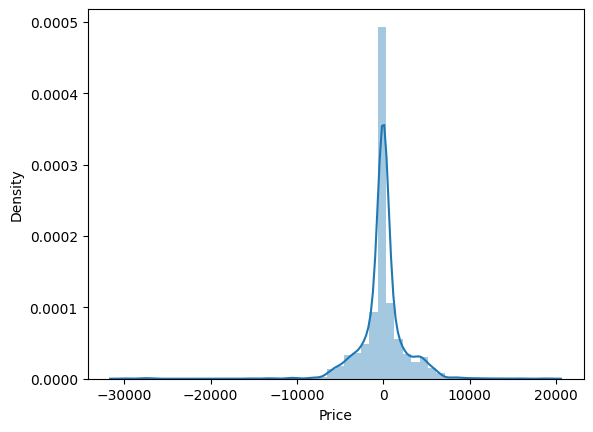

In [41]:
predict(DecisionTreeRegressor())

#### Random Forest

Model: RandomForestRegressor
Training Score: 0.9542068873646108

R2 Score: 0.7982251768853778
MAE: 1230.1957329689888
MSE: 4033994.8381565567
RMSE: 2008.480728848688


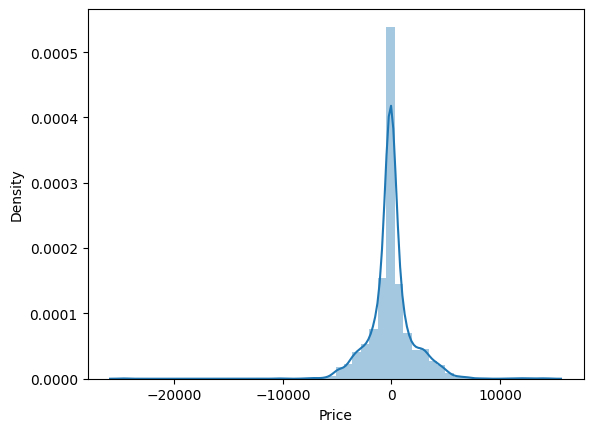

In [42]:
predict(RandomForestRegressor())

#### XgBoost

Model: XGBRegressor
Training Score: 0.9267073215715829

R2 Score: 0.83376584766048
MAE: 1189.9331300884528
MSE: 3323445.9191274503
RMSE: 1823.0320674983889


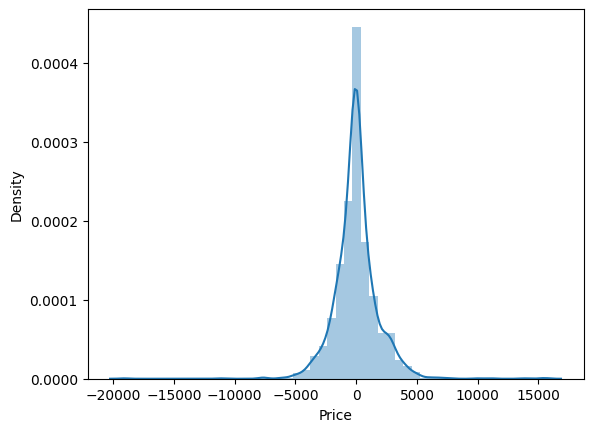

In [43]:
predict(XGBRegressor())

Among the evaluated models, the **XGBRegressor outperformed DecisionTreeRegressor and RandomForestRegressor**, achieving the highest R² score (83.37%) and the lowest RMSE (1823.03) and MAE (1189.93), making it the most accurate and reliable model for predicting the target variable.

Here the **XGBRegressor** model showed signs of overfitting, as it achieved high accuracy on the training data but less on the test data. To address this, hyperparameter tuning was performing using GridSearchCV to optimize the model's parameters, reduce overfitting, and improve its generalization on unseen data.

### Hyperparameter tuning

In [44]:
# Defining the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],  
    'max_depth': [3, 5, 7],          
    'learning_rate': [0.01, 0.1, 0.2], 
    'subsample': [0.8, 1.0],        
    'colsample_bytree': [0.8, 1.0]
}

In [45]:
# Define the model
xgb = XGBRegressor()

# Define the GridSearchCV
xgboost_gridsearch = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, scoring='r2', verbose=2, n_jobs=-1)
xgboost_gridsearch.fit(X_train, y_train)

# Get the best parameters and score
print("Best Parameters:", xgboost_gridsearch.best_params_)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}


In [46]:
# Save the best model obtained from GridSearchCV
xgb_model = xgboost_gridsearch.best_estimator_

# Predictions
y_pred = xgb_model.predict(X_test)
print(f'R2 Score: {r2_score(y_test,y_pred)}')

R2 Score: 0.8395019111091457


After tuning the model, the R² score increased slightly to 83.95%, indicating a modest improvement in the model's performance.

In [48]:
# Saving the model
import joblib
joblib.dump(xgb_model,'flight_fare_model.pkl')

['flight_fare_model.pkl']